# Préparation des données

In [15]:
# Chargment des bibliothèques
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import joblib


# Chargement du dataset
df = pd.read_csv("../data/raw/winequality-red.csv", sep=';')

## Gestion des valeurs manquantes
- Suppression de lignes ou colonnes trop incomplètes.
- Imputation (remplacement par la moyenne, la médiane, le mode…).
- Utilisation de modèles d’imputation plus avancés (KNNImputer, IterativeImputer).

> _Objectif_ : ne pas perturber l’apprentissage 


In [16]:
# Gestion des valeurs manquantes
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

- _Remarque_ : Ici, il n'y à aucune valeu manquante alors cette étape n'est pas nécéssaire.

## Mise à l'échelle

- StandardScaler : moyenne = 0, écart-type = 1.
- MinMaxScaler : valeurs entre 0 et 1.

> _Objectif_ : adapter les données aux modèles sensibles aux différences d'échelle (ex. KNN, SVM, régression linéaire).

In [17]:
# Sélection des features numériques
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
# Initialisation du scaler
scaler = StandardScaler()
# Ajustement sur le dataset (uniquement sur train plus tard)
df_scaled = df.copy()
df_scaled[num_cols] = scaler.fit_transform(df[num_cols])
# Vérification rapide
df_scaled.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,-0.787823
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,-0.787823
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,-0.787823
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,0.450848
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,-0.787823


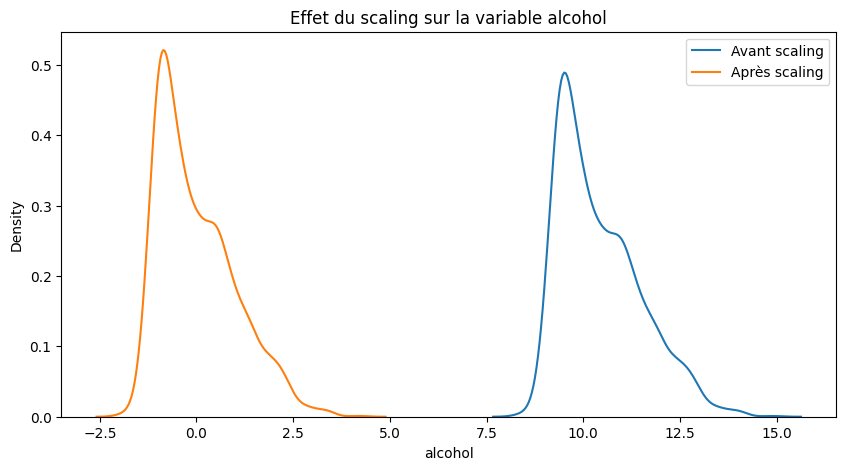

In [18]:
# Visualisation de l'effet de la mise à l'échelle : ici exemple sur l'alcool
plt.figure(figsize=(10,5))
sns.kdeplot(df['alcohol'], label='Avant scaling')
sns.kdeplot(df_scaled['alcohol'], label='Après scaling')
plt.legend()
plt.title("Effet du scaling sur la variable alcohol")
plt.show()


# # Séparation des données

- Jeu de données d'entrainement
- Jeu de données de test
- Jeu de validation

> _Objectif_ : Diviser les données afin d'allouer des paquest à chaque étape de l'entrainement. 

In [19]:
# Définition des features et de la cible
X = df_scaled.drop("quality", axis=1)
y = df_scaled["quality"]

# Séparation en train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,          # 20% pour le test
    random_state=42,        # pour la reproductibilité
    stratify=y              # utile si classes déséquilibrées
)

print("Taille du jeu d'entraînement :", X_train.shape)
print("Taille du jeu de test :", X_test.shape)


Taille du jeu d'entraînement : (1279, 11)
Taille du jeu de test : (320, 11)


- _Remarque_ : Dans le dataset Wine Quality, certaines notes de qualité (quality) sont rares. La stratification garantit que la répartition des classes (par ex. qualité 5, 6, 7) reste la même dans train et test.

In [20]:
# Sauvegarde des splits pour fixer la seed du randomstate
joblib.dump((X_train, X_test, y_train, y_test), "../data/processed/splits.pkl")

['../data/processed/splits.pkl']

## Sélection des variables

- Corrélations fortes
- Importances des features avec des modèles simples
- Techniques avancées telles que la PCA

> _Objectif_ : Identifier les variables les plus pertinentes, réduire les features pour accélérer l'entrainement du modèle.

- _Remarque_ : Le jeu de données étant de taille modérée (11 features), il n'est pas nécéssaire de réaliser une data selection. 

Celà dit, voici un tableau récapitulatif des méthodes de séléction : 

| Méthode                             | Principe                                            | Exemple pratique                                                     |
| ----------------------------------- | --------------------------------------------------- | -------------------------------------------------------------------- |
| **Filtrage statistique**            | Retire les variables peu corrélées à la cible       | `SelectKBest`, test de corrélation                                   |
| **Wrapper (sélectif)**              | Teste différentes combinaisons via cross-validation | `RFE` (Recursive Feature Elimination)                                |
| **Basé sur l’importance du modèle** | Utilise les scores de feature importance            | `RandomForest.feature_importances_`, `PermutationImportance`, `SHAP` |
